# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 14.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.
Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте:
     https://contest.yandex.ru/contest/6469/run-report/9994024/
* Максимальная оценка: 
     13

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [587]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [588]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.678997393048874

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [589]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=100000)
(X**2).sum(axis=1).mean()

20.004707175919851

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [590]:
from matplotlib import pyplot as plt
%matplotlib inline

In [591]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

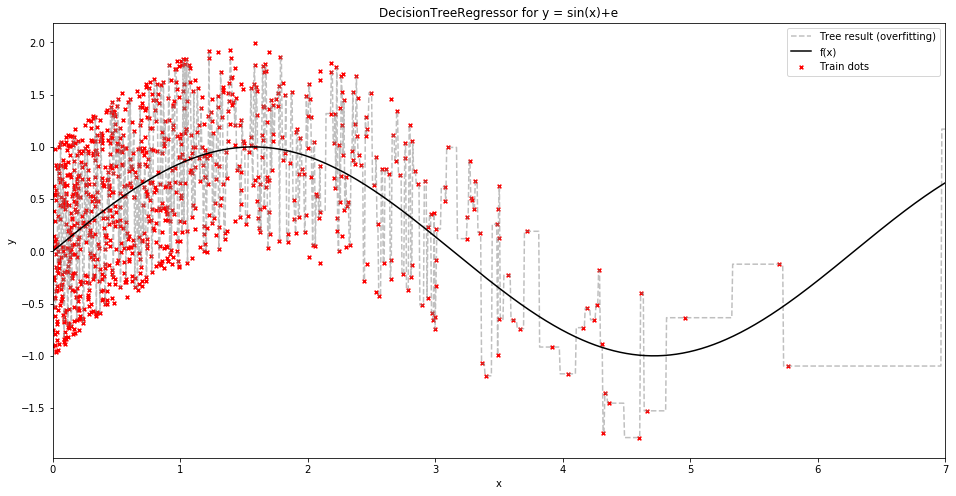

In [592]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.title("DecisionTreeRegressor for y = sin(x)+e")
plt.xlabel('x')
plt.ylabel('y')

sample_size = 1000
np.random.seed(42)
def create_x(sample_size = sample_size):
    x = np.random.exponential(size = sample_size)

    y = f(x) + np.random.uniform(low = -1.0, high = 1.0, size = sample_size)
    X = x[:, np.newaxis]
    return X, y

def draw(X, y, max_depth=None, draw_dots = True, draw_plot = True, draw_real = True):
    clf = DecisionTreeRegressor(max_depth = max_depth)
    clf.fit(X, y)

    x_min = np.min(X)*0.9
    x_max = np.max(X)*1.1
    x_int = linspace
    if draw_dots:
        plt.scatter(X, y, label = 'Train dots', s = 14, c='r', marker = 'x')
    if draw_plot:
        plt.plot(x_int, clf.predict(x_int[:, np.newaxis]), '--', label = 'Tree result (overfitting)', color = 'grey', alpha = 0.5)
    if draw_real:
        plt.plot(x_int, [f(t) for t in x_int], label = 'f(x)', c = 'black')
    plt.xlim(min(linspace), max(linspace))

    return clf
X, y = create_x(sample_size)
_ = draw(X, y)


plt.legend()

plt.show()

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

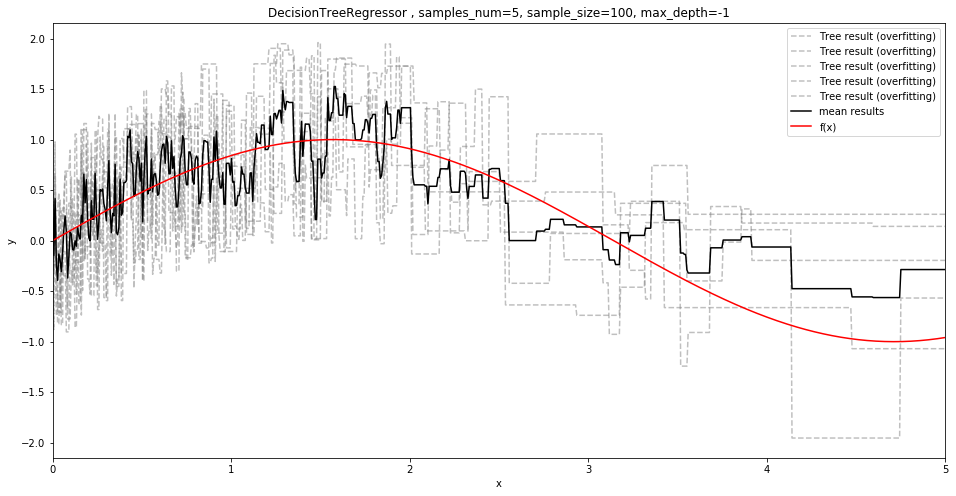

In [593]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


# sample_size = 1000
# samples_num = 20

def draw_many_grapth(samples_num = 5, sample_size = 100, max_depth = None):
    plt.figure(figsize=(16,8))
    plt.title("DecisionTreeRegressor for y = sin(x)+e")
    plt.xlabel('x')
    plt.ylabel('y')



    models = []
    x_int = linspace

    for i in range(samples_num):
        X, y = create_x(sample_size)
        model = draw(X, y, max_depth=max_depth, draw_dots=False, draw_real=False)
        models.append(model)

    x_int = linspace
    res = np.array([clf.predict(x_int[:, np.newaxis]) for clf in models])
    y_mean = np.mean(res, axis = 0)
    plt.title("DecisionTreeRegressor , samples_num=%d, sample_size=%d, max_depth=%d"%(samples_num, 
                                                                                      sample_size, 
                                                                                      max_depth if max_depth is not None else -1))
    plt.plot(x_int, y_mean, label = "mean results", c = "black")
    plt.plot(x_int, [f(t) for t in x_int], label = 'f(x)', c = 'red')
    plt.xlim(0,5)
    plt.legend()

    plt.show()
    
draw_many_grapth()

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

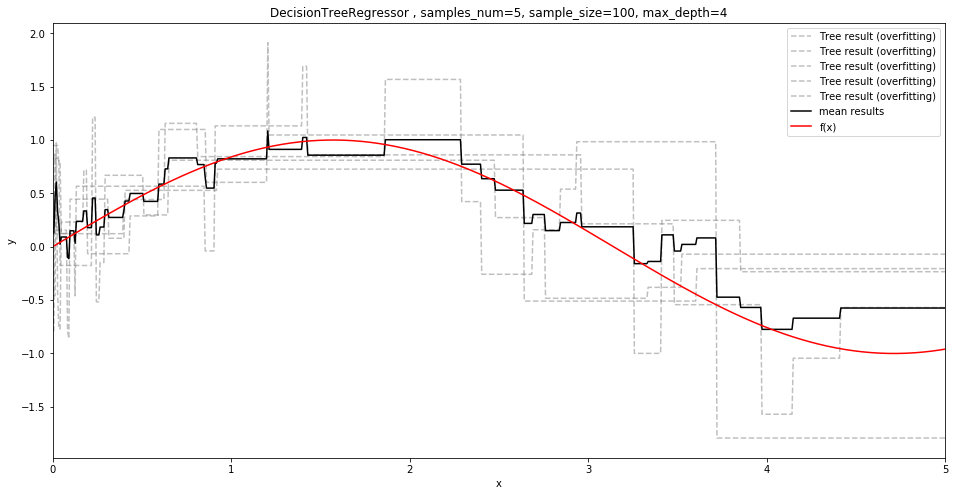

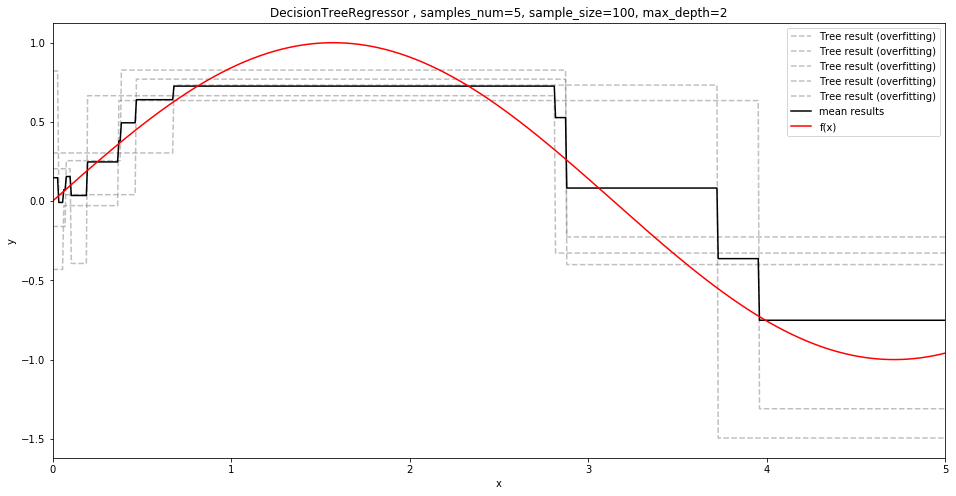

In [594]:
draw_many_grapth(max_depth=4)
draw_many_grapth(max_depth=2)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**

Чем больше глубина дерева, тем меньше разброс(variance) и больше смещение(bias).
(Нулевой алгоритм (все - 0)- дает большой разброс и маленькое смещение)

Можно утверждать, что бесконечно глубокое дерево на достаточно большой выборке будет иметь смещение, близко к нулю.

Чем больше x - тем предсказание хуже <- связано с малым колечеством точек для большого x

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

#### Краткое описание
  После генерации всех необходимых объектов, должна вызываться функция compute_bias_variance_fixed_samples.

    Рекомендации:
    * Создайте вектор объектов для оценивания интеграла по $x$, затем вектор зашумленных правильных ответов.
      Оцените мат. ожидание шума с помощью генерации отдельной шумовой выборки длины objects_num.
    * Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

    :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
     LinearRegression, Lasso, RandomForestRegressor ...)
    :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
     такой же длины. Примеры: np.sin, lambda x: x**2
    :param x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в
     выборке). По умолчанию np.random.uniform
    :param noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и
     имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform
    :param sample_size: число объектов в выборке
    :param samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
    :param objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x
    :param seed: seed для функции np.random.seed

    :return bias: смещение алгоритма regressor (число)
    :return variance: разброс алгоритма regressor (число)

В качестве допущения, будем оценивать $ E_X\left[\mu(X)\right](x) $ как средний ответ на $x$ из samples_num алгоритмов, обученных на своих подвыборках $X$

    Рекомендации:
* $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума
$\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины
       sample_size и усреднить предсказания на сгенерированных ранее объектах.

    :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
     LinearRegression, Lasso, RandomForestRegressor ...)
    :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
     такой же длины. Примеры: np.sin, lambda x: x**2
    :param samples: samples_num выборк длины sample_size для оценки интеграла по X
    :param objects: objects_num объектов для оценки интеграла по x
    :param noise: шумовая компонента размерности (samples_num, sample_size)
    :param mean_noise: среднее шумовой компоненты

    :return bias: смещение алгоритма regressor (число)
    :return variance: разброс алгоритма regressor (число)


In [655]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin


def compute_bias_variance(regressor, dependence_fun,
                          x_generator=np.random.uniform,
                          noise_generator=np.random.uniform,
                          sample_size=100, samples_num=300,
                          objects_num=200, seed=1234):
    np.random.seed(seed)
    objects = x_generator(size=objects_num)  # fit
    samples = x_generator(size=(samples_num, sample_size))  # predict
    noise = noise_generator(size=(samples_num, sample_size))  # noise for train
    noise_objects = noise_generator(size=objects_num)

    mean_noise = np.mean(noise_generator(size=objects_num))  # mean noise

    return compute_bias_variance_fixed_samples(regressor, dependence_fun, samples, objects, noise, mean_noise,
                                               noise_objects)


def compute_bias_variance_fixed_samples(regressor, dependence_fun, samples, objects, noise, mean_noise,
                                        noise_objects=False):
    f = dependence_fun(objects)
    y = np.array(list(map(dependence_fun, samples)))

    y_predicted = np.empty((samples.shape[0], objects.shape[0]))
    mse = np.zeros(len(samples) + 1)
    for i in range(len(samples)):
        # regressor
        y_predicted[i] = regressor.fit(samples[i, np.newaxis].T, y[i] + noise[i]).predict(objects[:, np.newaxis])
        if type(noise_objects) != type(False):
            t = np.mean((y_predicted[i] - f - noise_objects) ** 2)
            mse[i] = t

    mean_predict = np.mean(y_predicted, axis=0)
    bias = np.mean((mean_predict - f - mean_noise) ** 2)
    variance = np.mean((y_predicted - mean_predict[np.newaxis, :]) ** 2)
    sigma = np.std(noise)**2
    mse = np.mean(mse)
    if type(noise_objects) == type(False):
        return bias, variance
    else:
        return bias, variance, sigma, mse

# Контест сдался, проверим теперь bias-variance trade-off

In [658]:
regressor = DecisionTreeRegressor()
f = lambda x: 5*np.sin(5*x)
generator = lambda size: np.random.normal(0, 0.3, size=size)

res = {'bias':    [],
       'variance':[],
       'sigma':   [],
       'mse':     []
      }
for i in range(1000):
    bias, variance, sigma, mse = compute_bias_variance(regressor, f, generator, seed = i)
    res['bias'].append(bias)
    res['variance'].append(variance)
    res['sigma'].append(sigma)
    res['mse'].append(mse)

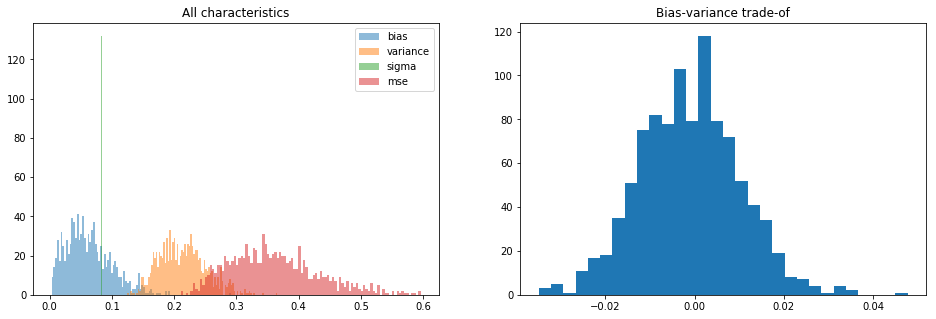

Mean of bias variance trade of  -0.001048526


In [675]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16,5)
ax1.set_title("All characteristics")
for key, lst in res.items():
    ax1.hist(lst, label = key, bins = 100 if key != 'sigma' else 20, alpha = 0.5)
ax1.legend()
# plt.show()
ax2.set_title('Bias-variance trade-of')
bias_variance_trade_of = np.array(res['mse']) - np.array(res['variance']) - np.array(res['sigma']) - np.array(res['bias'])
ax2.hist(bias_variance_trade_of, bins = 30)
plt.show()
print("Mean of bias variance trade of  %4.9f"%bias_variance_trade_of.mean())

Идеально

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [701]:
# from importlib import reload
# import hw3code

# reload(hw3code)
# I use my own function to calculate mse and variance

In [676]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [677]:
regressors = [LinearRegression(), DecisionTreeRegressor(), 
              RandomForestRegressor(), GradientBoostingRegressor()
             ]
generators = [
              lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)
             ]

In [697]:
df_bias     = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                           index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)
df_sigma    = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)
df_mse      = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [741]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from tqdm import tqdm

f = lambda x: 5*np.sin(10*x)
df_bias_std     = pd.DataFrame(columns=df_bias.columns, index=df_bias.index) 
df_variance_std = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)
df_sigma_std    = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)
df_mse_std      = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

num_est = 10

for n_row, regressor in tqdm(enumerate(regressors)):
    for n_col, generator in enumerate(generators):
        bias, variance, sigma, mse = [],[],[],[]
        for i in range(num_est):
            t = list(compute_bias_variance(regressor, f, x_generator=generator, seed = i))
            bias.append(t[0])
            variance.append(t[1])
            sigma.append(t[2])
            mse.append(t[3])

        df_bias.iloc[n_row, n_col]     = np.array(bias).mean()
        df_variance.iloc[n_row, n_col] = np.array(variance).mean()
        df_sigma.iloc[n_row, n_col]    = np.array(sigma).mean()
        df_mse.iloc[n_row, n_col]      = np.array(mse).mean()

        df_bias_std.iloc[n_row, n_col]     = np.array(bias).std()
        df_variance_std.iloc[n_row, n_col] = np.array(variance).std()
        df_sigma_std.iloc[n_row, n_col]    = np.array(sigma).std()
        df_mse_std.iloc[n_row, n_col]      = np.array(mse).std()


0it [00:00, ?it/s]
1it [00:05,  5.15s/it]
4it [07:08, 111.54s/it]


In [760]:
print("Стандартое отклонение шума - одинаковое")
df_sigma

Стандартое отклонение шума - одинаковое


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0835086,0.0835142,0.0835142,0.0835142
DecisionTree,0.0835086,0.0835142,0.0835142,0.0835142
RandomForest,0.0835086,0.0835142,0.0835142,0.0835142
GradientBoosting,0.0835086,0.0835142,0.0835142,0.0835142


In [749]:
print("Среднее отклонение")
df_bias

Среднее отклонение


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.5224,8.18899,11.4788,11.1501
DecisionTree,0.14349,0.129861,0.0073621,0.00246437
RandomForest,0.292562,0.229921,0.0277521,0.00674471
GradientBoosting,0.150163,0.136612,0.0233332,0.00334703


In [751]:
print("Средняя дисперсия отклонения")
df_bias_std

Средняя дисперсия отклонения


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.493183,0.535646,0.629857,0.888584
DecisionTree,0.103075,0.0714367,0.00369406,0.00141197
RandomForest,0.142249,0.0915263,0.0120805,0.00340929
GradientBoosting,0.103986,0.0722093,0.00515836,0.00162057


In [753]:
print("Средний разброс [variance.mean()]")
df_variance

Средний разброс [variance.mean()]


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.262487,0.241461,0.209771,0.185901
DecisionTree,0.453454,0.45525,0.34219,0.147554
RandomForest,0.34329,0.325255,0.266124,0.0985204
GradientBoosting,0.417305,0.411843,0.30331,0.11747


In [759]:
print("MSE стандартое отклонение")
df_mse_std

MSE стандартое отклонение


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.571624,0.51207,0.65535,0.865978
DecisionTree,0.184338,0.161594,0.0202697,0.0062355
RandomForest,0.225438,0.141947,0.0241585,0.00834008
GradientBoosting,0.185039,0.16167,0.0186307,0.00668722


In [754]:
print("Дисперсия разброса [variance.std()]")
df_variance_std

Дисперсия разброса [variance.std()]


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0227853,0.0374082,0.0137376,0.013192
DecisionTree,0.0955978,0.0995911,0.0177506,0.00410752
RandomForest,0.0843995,0.0585863,0.0136663,0.00436296
GradientBoosting,0.0956537,0.0978576,0.0172841,0.00468655


In [758]:
print("MSE среднее")
df_mse

MSE среднее


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.8913,8.45142,11.7527,11.3956
DecisionTree,0.673068,0.659388,0.431145,0.230722
RandomForest,0.709469,0.630105,0.376793,0.18571
GradientBoosting,0.644183,0.622672,0.410386,0.201689


In [702]:
print("bias")
df_bias

bias


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1006,9.05214,11.4951,10.8398
DecisionTree,0.29306,0.116334,0.0078387,0.00184986
RandomForest,0.354155,0.242275,0.0320227,0.00658453
GradientBoosting,0.2964,0.12479,0.0224901,0.00295416


In [703]:
print("variance")
df_variance

variance


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.278044,0.227926,0.211472,0.161108
DecisionTree,0.45238,0.527072,0.339096,0.146839
RandomForest,0.338319,0.369281,0.263498,0.0976638
GradientBoosting,0.416206,0.482063,0.300226,0.116904


In [705]:
print('MSE')
df_mse

MSE


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.3832,9.29253,11.7293,11.0305
DecisionTree,0.832069,0.748915,0.434028,0.232614
RandomForest,0.77447,0.721776,0.38385,0.184973
GradientBoosting,0.800517,0.712246,0.408477,0.202704


In [720]:
print("bias variance tradeoff")
df_bias/df_mse+df_variance/df_mse+df_sigma/df_mse

bias variance tradeoff


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,1.00632,1.00759,1.00515,1.00485
DecisionTree,0.995398,0.96999,0.990645,0.996169
RandomForest,1.00104,0.962335,0.986202,1.01248
GradientBoosting,0.993616,0.968607,0.993324,1.00093


In [728]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.278044,0.227926,0.211472,0.161108
DecisionTree,0.45238,0.527072,0.339096,0.146839
RandomForest,0.338319,0.369281,0.263498,0.0976638
GradientBoosting,0.416206,0.482063,0.300226,0.116904


In [766]:
(df_bias/df_mse).T.mean()

LinearRegression    0.973871
DecisionTree        0.109472
RandomForest        0.221808
GradientBoosting    0.131489
dtype: float64

In [769]:
(df_variance/df_mse).T.mean()

LinearRegression    0.020774
DecisionTree        0.699334
RandomForest        0.559214
GradientBoosting    0.657684
dtype: float64

In [770]:
(df_bias/df_mse).mean()

normal(0, 0.3)      0.457512
exponential(0.3)    0.437545
uniform(-1, 1)      0.281069
uniform(0, 1)       0.260514
dtype: float64

In [771]:
(df_variance/df_mse).mean()

normal(0, 0.3)      0.456437
exponential(0.3)    0.474147
uniform(-1, 1)      0.564224
uniform(0, 1)       0.442197
dtype: float64

__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:

**Ответ:**
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
       
       Алгоритм [процент varience от MSE]
       DecisionTree [66%] >~ GradientBoosting[62%] > RandomForest [54%] >> LinearRegression [2%]
       
       Согласуется : чем больше алгоритм переобучается - больше variance 
       Дисперсия - насколько сильно изменяется результат от разных выборок
       Простые семейста алгоритмов(напр. лин регр) - мальенькая дисперсия, сложные(напр. бустинг) - большая
       
       Если же брать bias, то все по другому:
       LinearRegression[97%] > RandomForest[22%] > GradientBoosting[12%] > DecisionTree[10%]
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
        
        Нельзя, иначе бы нам не давали так много генераторов (шутка).
        Если серьезно, то зависят, особенно для "сложных" моделей
        variance "сложных" моделей с "тяжелыми хвостами" (типо нормальных и экспоненциальных) - намного больше
        (результат очень сильно зависит от выборки)
        На первом задании это хорошо видно
        
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?
        
        Для нормального распределения. Это связано с переобучением, для решающих деревьев. Центральные - переобучаются для большого количества точек, а крайнее наоборот недообучаются - в сумме выходит не очень
        Для линейной регрессии bias и variance не зависит от распределения, может быть это главная причина, почему они в продакшене
        

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [781]:
generators[0](10)

array([-0.06190631, -0.45908667,  0.04936688, -0.20362564,  0.36253494,
       -0.03070812,  0.23160023, -0.37446278,  0.36681763, -0.22525786])

In [ ]:
from tqdm import tqdm

f = lambda x: 5*np.sin(10*x)
res = {}
generators_names = ["normal", "exponential", "uniform__1_1", "uniform_1_0"]
for n_row, regressor in tqdm(enumerate(regressors)):
    for n_col, generator in enumerate(generators):
        for dtype in ['sample_size', 'samples_num', 'objects_num']:
            for val in np.arange(100,1000,100):
                t = []
                if dtype == 'sample_size':
                    t = list(compute_bias_variance(regressor, f, x_generator=generator, seed = i, sample_size=val))
                if dtype == 'samples_num':
                    t = list(compute_bias_variance(regressor, f, x_generator=generator, seed = i, samples_num=val))
                if dtype == 'objects_num':
                    t = list(compute_bias_variance(regressor, f, x_generator=generator, seed = i, objects_num=val))
                if not str(regressor) in res:
                    res[str(regressor)] = {}
                if not generators_names[n_col] in res[str(regressor)]:
                    res[str(regressor)][generators_names[n_col]] = {}
                if not dtype+"_"+str(val) in  res[str(regressor)][generators_names[n_col]]:
                    res[str(regressor)][generators_names[n_col]][dtype+"_"+str(val)] = {}
                res[str(regressor)][generators_names[n_col]][dtype+"_"+str(val)] = {
                    "bias":t[0],
                    'variance':t[1],
                    'sigma':t[2],
                    'mse':t[3]
                    }

2it [00:35, 17.19s/it]

In [803]:
res

{'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)': {'normal': {'objects_num_100': {'bias': 13.140961562835983,
    'mse': 13.266182482031153,
    'sigma': 0.083058479460863782,
    'variance': 0.29792488538368644},
   'objects_num_200': {'bias': 12.078338430878709,
    'mse': 12.553769421513513,
    'sigma': 0.083029694724202255,
    'variance': 0.28791088993921354},
   'objects_num_300': {'bias': 11.867463588254035,
    'mse': 12.280759830470586,
    'sigma': 0.082960445131155816,
    'variance': 0.29055231304387896},
   'sample_size_100': {'bias': 12.078338430878709,
    'mse': 12.553769421513513,
    'sigma': 0.083029694724202255,
    'variance': 0.28791088993921354},
   'sample_size_200': {'bias': 12.118971376081618,
    'mse': 12.379120419930729,
    'sigma': 0.082800097294914859,
    'variance': 0.12908742045798552},
   'sample_size_300': {'bias': 12.123917773025477,
    'mse': 12.31193371743203,
    'sigma': 0.082968676110220282,
    'variance': 0.0

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

In [1]:
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

Правильно

Лучшее разбиение $$ Gain(S, A) = I(S) - \left(\frac{|S_L|}{|S|}\cdot I(S_L) + \frac{|S_R|}{|S|}\cdot I(S_R) \right),$$
Gini index $$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$

   Но под критерием Джини мы будем подразумевать следующую функцию:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.



In [3]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """    
    #Sort by feature
    ids = np.argsort(feature_vector)
    x = feature_vector[ids]
    y = target_vector[ids]
    
    #Find splits, thats chenge probabilities [1,1,1,0,1,0,0,0] --[ind]-> [3,4,5]
    where = np.diff(x) != 0
    thresholds = (x[:-1][where] + x[1:][where]) / 2

    
    num_ones = np.sum(y)
    feature_length = len(y)
    sums = np.cumsum(y)[:-1]
    splits = np.arange(1, feature_length)
    
    #probs of 1 in left/right
    p_left  = sums / splits
    p_right = (num_ones - sums) / (feature_length - splits)

    #gini
    s_left  = 2 * p_left * (1 - p_left)
    s_right = 2 * p_right *(1 - p_right)
    
    #gain
    ginis = -1 / feature_length * (splits * s_left + (feature_length - splits) * s_right)
    ginis = ginis[where]

    argmax = np.argmax(ginis)

    return thresholds, ginis, thresholds[argmax], ginis[argmax]
        

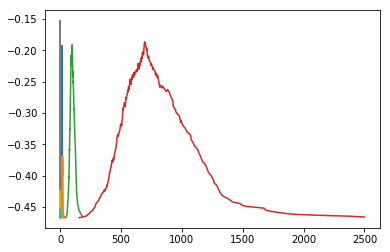

In [4]:
#Testing
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer().data, load_breast_cancer().target
feature_names = load_breast_cancer().feature_names
for i in range(10):
    t = find_best_split(X[:,i], y)
    t_x, t_y = t[0], t[1]
    plt.plot(t_x, t_y , label = feature_names[i])
plt.show()

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [5]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd

In [6]:
df = pd.read_csv('data/students.csv')

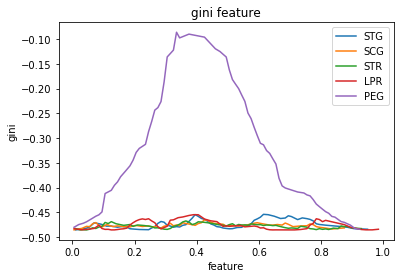

In [7]:
KEYS = df.keys()[:-1]
y = df[' UNS'].get_values()
plt.title("gini feature")
plt.xlabel('feature')
plt.ylabel('gini')
for key in KEYS:
#     print(df[key].get_values())
    x = df[key].get_values()
    t = find_best_split(x, y)
    plt.plot(t[0], t[1], label = key)
plt.legend()
plt.show()

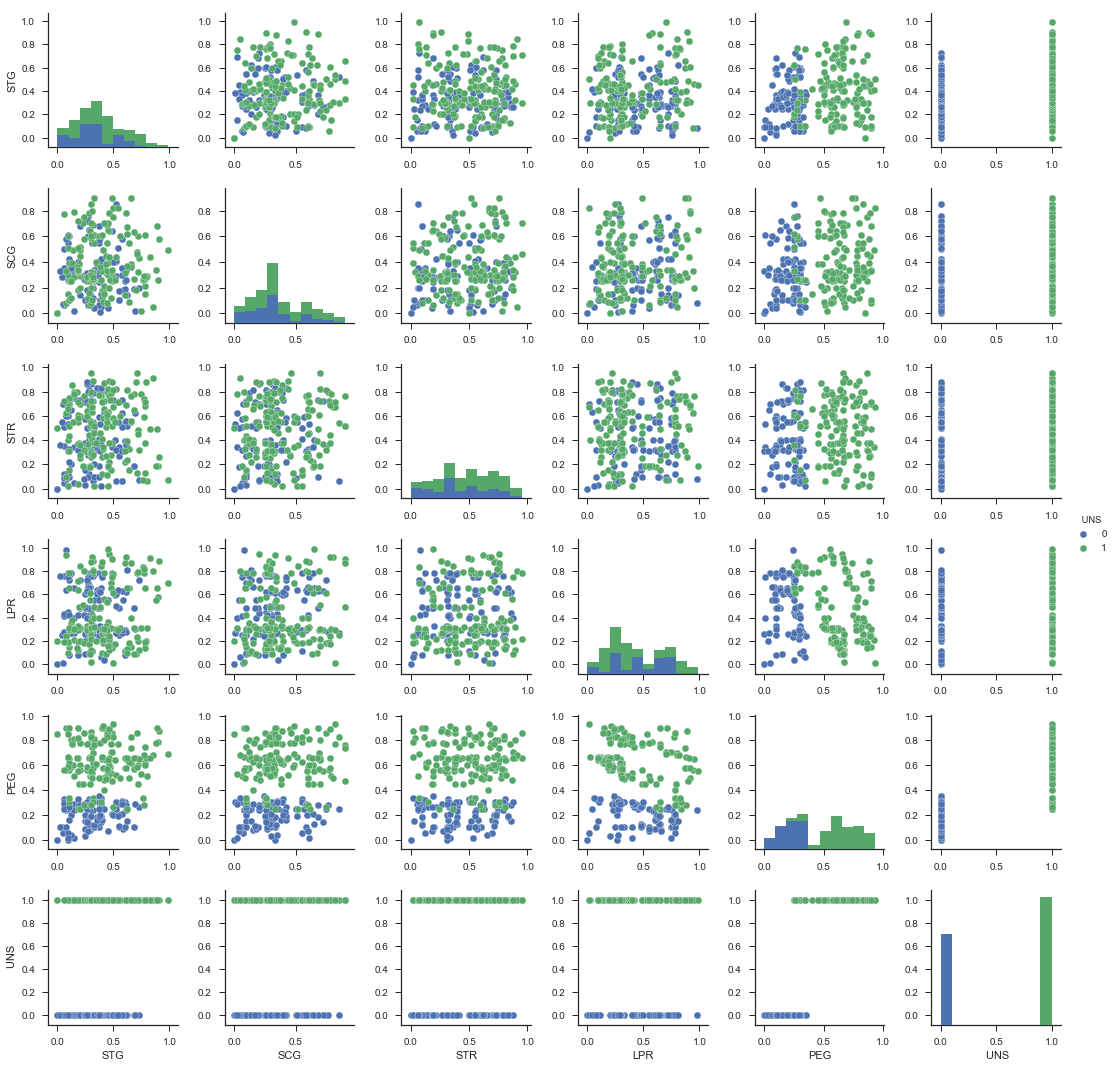

In [8]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue = ' UNS')
plt.show()

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

    Исходя из критерия джинни, разбивать стоит по критерию PEG.
    Результат визуально согласуется со scatter-графиками
    "Хороший признак" бьет выборку на два класса  почти идеально, gini почти 0 (Для идеального разбиения gini=0)
    [для scatter графиков]
    Для графика gini - оно похоже на гаусово распределение (перевернутое гауссовое распределения минус минимум) , 
    т.е есть один минимум, при удалении от которого gini сильно падает 
   
    Кривые для признаков, по которым деление практически невозможно - плоские, (gini не сильно зависит от разбиения)
    (-0.5 +- шум) // 
доказательство
$ p1 = p0 = 0.5 1-p1**2-p0**2 = 0.5 $

$ gini = -0.5*l/(l+r)-0.5*r/(l+r)) = -0.5 $

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types = None, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        #make cross_validation work correctly
        if feature_types is not None:
            if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
                raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        
    def _fit_node(self, sub_X, sub_y, node):
        #error != -> ==
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        #error use all feature
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}
            
            #to not use empy seqoense
            if len(np.unique(sub_X[:, feature])) == 1:
                continue
                
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    #error ratio = 1/ratio
                    ratio[key] = current_click / current_count
                #error sorted lambda 0
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if len(feature_vector) == 3:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                #error capital word
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        #np.logical_not(split)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if node['type'] == 'terminal':
            return node['class']
        feature = node['feature_split']
        if self._feature_types[feature] == 'real':
            threshold = node['threshold']
            if x[feature] < threshold:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[feature] == 'categorical':
            try:
                threshold = node['categories_split']
            except:
                print(node.keys())
            if x[feature] in threshold:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            raise "WrongCategoryError"



        pass

    def fit(self, X, y, feature_types = None):
        #make cross_validation work correctly
        if feature_types is not None:
            if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
                raise ValueError("There is unknown feature type")
            self._feature_types = feature_types
            #print(self._feature_types)
        if self._feature_types is None:
            raise ValueError("Don't know feature types")

        self._fit_node(X, y, self._tree)
        return self
    
    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    def score(self, X, y):
         return accuracy_score(self.predict(X), y) 


In [10]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer().data, load_breast_cancer().target

In [11]:
from sklearn.metrics import accuracy_score
model = DecisionTree(feature_types=['real' for i in range(X.shape[0])], max_depth = 2)
model.fit(X, y)
print("accuracy %4.4f"%accuracy_score(model.predict(X), y))

accuracy 1.0000


__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('data/agaricus-lepiota.data', header=None)

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()
for i in df.keys():
    df[i] = le.fit_transform(df[i].get_values())

In [15]:
X, y = df[df.keys()[1:]].get_values(), df[0].get_values()

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
model = DecisionTree(feature_types=['categorical' for i in range(X.shape[1])])
model.fit(X_train, y_train)

DecisionTree(feature_types=None, max_depth=None, min_samples_leaf=None,
       min_samples_split=None)

In [17]:
print("accuracy_score %4.4f"%accuracy_score(model.predict(X_test), y_test))

accuracy_score 1.0000


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [815]:
#ref, num of column with y
# "name" " [url, [y_key, [positive values of y]]]
urls = {
    "mushrooms"   : ["https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
                    ['p',  ['e']]
                    ],
    "tic-tac-toe" : ["https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",  
                    ['positive',['positive']]
                    ],
    "cars"        : ["https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",                  
                    ['unacc', ['unacc', 'acc']]
                    ],
    "nursery"     : ["https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",          
                    ['recommend', ['recommend', 'priority']]
                    ]
}

In [823]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

le = LabelEncoder()

def get_datasets(url, y_mask, get_only_df = False):
    df       = pd.read_csv(url)
    if not get_only_df:
        df       = shuffle(df, random_state = 42)
        keys = list(df.keys())
        keys.remove(y_mask[0])
        df[y_mask[0]] = [int(i in y_mask[1]) for i in df[y_mask[0]]]
        for key in keys:
            df[key] = le.fit_transform(df[key].get_values())
        X, y = df[keys].get_values(),  df[y_mask[0]].get_values()
        return X, y
    else:
        return df





In [829]:
scores = {} #datasets categorical / real / categorical_one_hot /sklearn
from sklearn.tree import DecisionTreeClassifier as DecisionTreeSk
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

for key, args in urls.items():
    print(args)
    X, y = get_datasets(args[0], args[1])
    scores[key] = {}
    model = DecisionTree()
    
    scores[key]['categorical features my tree'] = cross_val_score(model, X, y, cv = 10, 
                fit_params={'feature_types':['categorical' for i in range(X.shape[1])]},
                scoring=make_scorer(accuracy_score))

    scores[key]['real features my tree'] = cross_val_score(model, X, y, cv = 10, 
                fit_params={'feature_types':['real' for i in range(X.shape[1])]},
                scoring=make_scorer(accuracy_score))
    
    model = DecisionTreeSk()
    scores[key]['sklearn tree'] = cross_val_score(model, X, y, cv = 10, 
                scoring=make_scorer(accuracy_score))

    X = pd.get_dummies(pd.DataFrame(X), prefix_sep='_', columns=pd.DataFrame(X).keys()).get_values()
    model = DecisionTree()
    scores[key]['real features one-hot'] = cross_val_score(model, X, y, cv = 10, 
                fit_params={'feature_types':['real' for i in range(X.shape[1])]},
                scoring=make_scorer(accuracy_score))


# https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

['https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', ['p', ['e']]]
['https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', ['positive', ['positive']]]
['https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', ['unacc', ['unacc', 'acc']]]
['https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', ['recommend', ['recommend', 'priority']]]


In [830]:
scores_results_mean  = {}
scores_results_std   = {}
scores_results_print = {}

for df_name, o in scores.items():
    scores_results_mean[df_name] = {}
    scores_results_std[df_name]  = {}
    scores_results_print[df_name] = {}
    for method, lst in o.items():
        m, std = np.array(lst).mean(), np.array(lst).std()
        scores_results_mean[df_name][method] = m
        scores_results_std[df_name][method]  = std
        scores_results_print[df_name][method]  = "M = %2.4f      Std = %2.4f"%(m,std)

In [831]:
results = pd.DataFrame.from_dict(scores_results_print).T

In [832]:
results

,categorical features my tree,real features my tree,real features one-hot,sklearn tree
cars,M = 0.9838 Std = 0.0109,M = 0.9867 Std = 0.0069,M = 0.9832 Std = 0.0054,M = 0.9907 Std = 0.0059
mushrooms,M = 0.9996 Std = 0.0011,M = 1.0000 Std = 0.0000,M = 0.9996 Std = 0.0011,M = 1.0000 Std = 0.0000
nursery,M = 0.9967 Std = 0.0013,M = 0.9950 Std = 0.0009,M = 0.9976 Std = 0.0010,M = 0.9975 Std = 0.0016
tic-tac-toe,M = 0.9457 Std = 0.0254,M = 0.8799 Std = 0.0370,M = 0.9457 Std = 0.0254,M = 0.8861 Std = 0.0331


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Проанализируем результаты эксперимента
    
    Краткое описание выборок:
        Название                                     |  Краткое описание признаков       [всего признаков/ one-hot]
        mushroms - ядовит ли гриб                    | размер шляпки/ есть ли юбка / ...           [22/118]
        tic-tac-toe (крестики нолики) выиграет ли х  | 9 ячеек (пусто/нолик/крестик)/ ...          [10, 29]
        cars - базопасна ли машина                   | цена покупки / цена продажи  / размер / ... [7 / 21]
        nursery - хорошее ли медицинское учереждение |                                             [7 / 28]
    
    Все датасеты имеют категориальные признаки
    Для бинарных признаков - модели с реальные и категориальные признаками не отличаются
    Для категориальных     - "Реальные работают лучше", если бинарное отношение имеет интропритацию
                             "low" < "midle" < "hight"
    Для деревьев           - One-hot идеален(позволяет делать самые сложные гипотезы), но иногда может переобучиться 
                                (сигма большая (разброс результатов на  кросс валидации))
    

Все работают примерно одинаково, sklearn и one-hot чуть получше 

    Улучшить можно
        - Признаки поменять на имеющие бинарное отношение ("low", "midle", "hight")  -> (1,2,3) 
             (я не уверен что это сейчас работает)
        - Добавить счетчики
 

**Ответ:**

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [106]:
df = pd.read_csv("data/BNP/train.csv").fillna(0)[:10000]

In [105]:
df = pd.read_csv('data/BNP/top10k.csv', index_col=None)

In [107]:
y = df['target'].get_values()
X = df[list([i[0] for i in filter(lambda x:x[1] != np.dtype, zip(df.keys()[2:], df.dtypes[2:]))])].get_values()

In [37]:
cv_scores = []
models = [DecisionTreeClassifier(), BaggingClassifier(), RandomForestClassifier()]
for model in models:
    cv_scores.append(cross_val_score(model, X, y, cv=3, scoring = 'accuracy'))

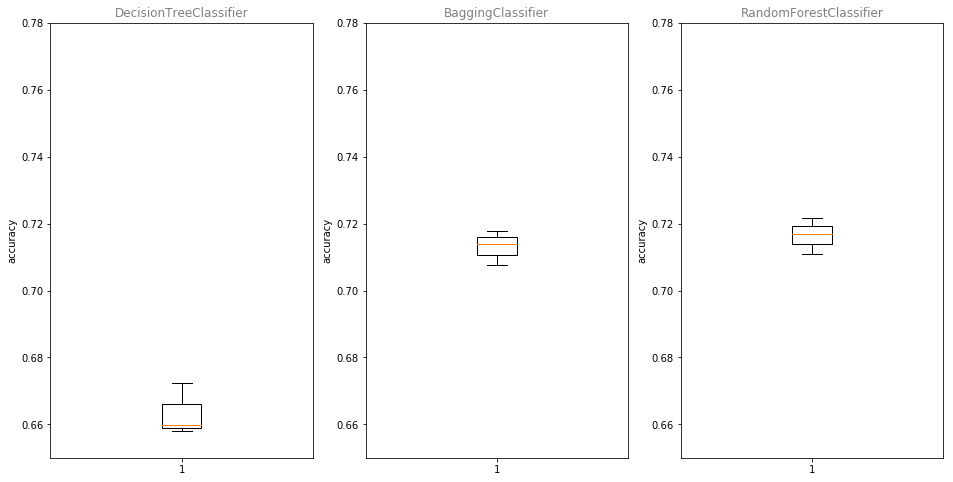

In [55]:
fig, ax_list = plt.subplots(1,3)
plt.title('scores')
fig.set_size_inches(16,8)

for ax, model, res in zip(ax_list, models, cv_scores):
    ax.boxplot(res)
    ax.set_title(str(model).split('(')[0], alpha = 0.5)
    ax.set_ylabel('accuracy')
    ax.set_ylim(0.65, 0.78)
plt.legend()
plt.show()

Сделано

#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [114]:
model = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42, n_jobs=-1)
n_estimators_list = np.arange(20, 5001, 20)
scores_test = []
scores_train = []
num_of_trees = []

max_trees  = 5000
split_size = 20

for n in tqdm(range(int(max_trees/split_size))):
    model.set_params(n_estimators=model.n_estimators + split_size)
    model.fit(X_train, y_train)
    num_of_trees.append(model.n_estimators)
    scores_test.append(accuracy_score(y_test, model.predict(X_test)))
    scores_train.append(accuracy_score(y_train, model.predict(X_train)))
    model.n_estimators += split_size

100%|██████████| 250/250 [31:57<00:00, 15.35s/it]


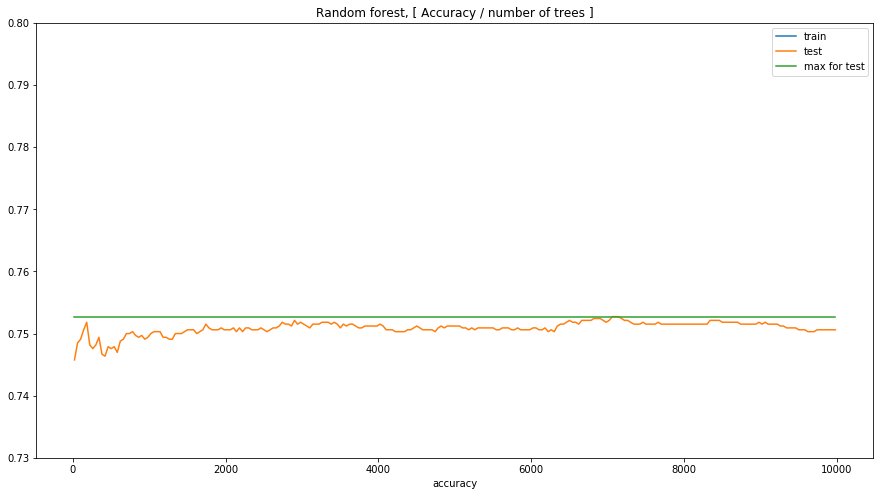

In [118]:
plt.figure(figsize = (15,8))
plt.title("Random forest, [ Accuracy / number of trees ]")
plt.xlabel("Number of trees")
plt.xlabel("accuracy")

plt.plot(num_of_trees, scores_train, label = "train")
plt.plot(num_of_trees, scores_test, label = "test")
plt.plot(num_of_trees, [max(scores_test)]*len(num_of_trees), label = "max for test")

plt.ylim(0.73,0.8)
plt.legend()
plt.show()


Видимо данные очень хорошие (тестовая и тренировачная выборка имеют одинаковые распределения)

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [7]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [110]:
dtrain = xgb.DMatrix(X_train, y_train)

In [112]:
def f(params_hp):
    cv_results = xgb.cv(params_hp, 
                        dtrain, 
                        nfold = 3,
                        metrics = 'logloss')
    return -cv_results['test-logloss-mean'].tolist()[-1]


fspace = {
    'gamma'          : hp.uniform('gamma', 0, 0.3),
    'learning_rate'  : hp.uniform('learning_rate', 0.03, 0.3),
    'max_depth'      : hp.choice( 'max_depth', [2, 3, 4, 5]),
    'lambda'         : hp.uniform('lambda', 0, 0.3),
    'objective'      : hp.choice('objective', ['binary:logistic'])
}


best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50)

In [113]:
best

{'gamma': 0.14748506871537348,
 'lambda': 0.14301789467604678,
 'learning_rate': 0.03056534520362707,
 'max_depth': 2,
 'objective': 0}

In [115]:
params = best
params['max_depth']    = 4
params['objective']    = 'binary:logistic'

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score, roc_auc_score
print("Tuned xgboost accuracy %4.4f"%accuracy_score(y_test, y_pred))
y_pred = model.predict_proba(X_test)[:,1]
print("Tuned xgboost auc-roc  %4.4f"%roc_auc_score(y_test, y_pred))

Tuned xgboost accuracy 0.7573
Tuned xgboost auc-roc  0.7168


__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

In [237]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter


df = pd.read_csv('data/BNP/train.csv')[:10000].fillna(0)
y = df['target'].get_values()
del df['target']
del df['ID']

def is_num(key):
    if df[key].dtype == np.dtype('float64'):
        return True
    return False
    
def is_cat(key):
    if df[key].dtype != np.dtype('float64'):
        if len(df[key].unique())<=50:
            return True
    return False

key_norm = list(filter(lambda x:  is_num(x), df.keys()))
key_cat  = list(filter(lambda x:  is_cat(x), df.keys()))
key_bad  = list(filter(lambda x:  not (is_cat(x) or is_num(x)), df.keys()))

#one hot
df_one_hot = pd.concat([df[key_norm].T, pd.get_dummies(df[key_cat]).T]).T

#labels
le = LabelEncoder()
df_labels = df.copy()
for key in key_cat:
    df_labels[key] = le.fit_transform([str(i) for i in df[key].get_values()])
    
for key in key_bad:
    del df_labels[key]

#count
c = 1
counters_dict = {}
df_counters = df.copy()
df['target'] = y

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

for key in key_cat:
    dct = {}
    C = len(df[key].unique())*c
    for uniq_val in df[key].unique():
        t = X_train[X_train[key] == uniq_val]
        dct[uniq_val] = (t['target'].sum()+c)/(len(t)+C)
    counters_dict[key] = dct
    df_counters[key] = [dct[i] for i in df[key]]

for key in key_bad:
    del df_counters[key]
    
del df['target']

In [300]:
import time

In [301]:
def best_model_xgboost(X_train, y_train, X_test, y_test, name = None):
    def f(params_hp):
#         cv_results = xgb.cv(params_hp,   #it's not overfittiong, but we compare this with others algorithms
#                             dtrain, 
#                             nfold = 3,
#                             metrics = 'auc')
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)    #not very honest, we improve test score, not validation 
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        return -auc#cv_results['test-auc-mean'].tolist()[-1]


    tree_depth = [2, 3, 4, 5]
    iterations = [10, 20, 30, 50, 200]
    fspace = {
        'gamma'          : hp.uniform('gamma', 0, 0.3),
        'learning_rate'  : hp.uniform('learning_rate', 0.03, 0.3),
        'max_depth'      : hp.choice( 'max_depth', tree_depth),
        'lambda'         : hp.uniform('lambda', 0, 0.3),
        'n_estimators'   : hp.choice('n_estimators', iterations),
        'objective'      : hp.choice('objective', ['binary:logistic'])
    }
    print(name)
    DM = xgb.DMatrix(X_train, y_train)
    best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10)
    best['max_depth'] = tree_depth[best['max_depth']]
    best['objective'] = 'binary:logistic'
    best['n_estimators'] = iterations[best['n_estimators']]
    print("\n".join([i[0]+'\t'+str(i[1]) for i in best.items()]))
    
    model = xgb.XGBClassifier(**best)
    model.fit(X_train, y_train)
    print("accuracy %4.8f"%accuracy_score(y_test, model.predict(X_test)))
    print("roc_auc  %4.8f"%roc_auc_score(y_test,  model.predict_proba(X_test)[:,1]))
    
    return best

for df, name in zip([df_one_hot, df_labels, df_counters], 
                    ["One-hot encoding", "Label encoding", "couters encoding"]):
    ## Лика y через счетчик не - одинкового shape[0] train_test_split дает одинаковые индексы
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)
    start = time.time()
    best_model_xgboost(X_train[key_norm].get_values(), y_train, X_test[key_norm].get_values(), y_test, name = name)
    print('\n Evaluate in %4.7f sec\n'%(time.time()-start))

One-hot encoding
gamma	0.10684489497557097
lambda	0.2965081548237117
learning_rate	0.18641088860022564
max_depth	4
n_estimators	10
objective	binary:logistic
accuracy 0.75757576
roc_auc  0.70153351

 Evaluate in 22.6445310 sec

Label encoding
gamma	0.1097714878712973
lambda	0.21557227096905687
learning_rate	0.06806328706515938
max_depth	4
n_estimators	30
objective	binary:logistic
accuracy 0.75575758
roc_auc  0.70227779

 Evaluate in 47.0733690 sec

couters encoding
gamma	0.1250556501833521
lambda	0.08448865173551456
learning_rate	0.24127359570650014
max_depth	2
n_estimators	30
objective	binary:logistic
accuracy 0.75818182
roc_auc  0.70317622

 Evaluate in 42.6355059 sec



Все согласуется с теорией

Кодирование счетчиками и лейблами ожидаемо дало чуть более лучший результат чем one-hot
-  Оптимальная глубина дерева для one-hot - 4, это много, и такая модель должна чуть быстрее переобучаться
-  По той же причине, гамма для one-hot - самая большая
-  Для счетчиков, всего 50 деревьев (learning_rate тоже меньше). (Распределения y от категориальных признаков в тестовой и тренировочной выборках немного смещены). Сложная модель переобучается b на тестовой выборке выдает плохой результат
-  По времени: one-hot - самый быстрый. Только 1 или 0 при разбиении по признаку (меньше перебор)

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

In [261]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [299]:
def best_model_light(X_train, y_train, X_test, y_test, name = None):
    def f(params_hp):
        model = LGBMClassifier(**params_hp)
        model.fit(X_train, y_train)    
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        return -auc


    tree_depth = [2, 3, 4, 5]
    iterations = [10, 20, 30, 50, 200]
    fspace = {
        'max_depth': hp.choice('max_depth', tree_depth),
        'n_estimators': hp.choice('n_estimators', iterations),
        'reg_lambda': hp.uniform('reg_lambda', 0, 0.3),
        'learning_rate': hp.uniform('learning_rate', 0.03, 0.3)
    }
    
    print(name)
    best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10)
    best['max_depth'] = tree_depth[best['max_depth']]
    best['n_estimators'] = iterations[best['n_estimators']]
    print("\n".join([i[0]+'\t'+str(i[1]) for i in best.items()]))
    
    model = LGBMClassifier(**best)
    model.fit(X_train, y_train)
    print("accuracy %4.8f"%accuracy_score(y_test, model.predict(X_test)))
    print("roc_auc  %4.8f"%roc_auc_score(y_test,  model.predict_proba(X_test)[:,1]))
    
    return best

for df, name in zip([df_one_hot, df_labels, df_counters], 
                    ["One-hot encoding", "Label encoding", "couters encoding"]):
    ## Лика y через счетчик не - одинкового shape[0] train_test_split дает одинаковые индексы
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)
    start = time.time()
    best_model_light(X_train[key_norm].get_values(), y_train, X_test[key_norm].get_values(), y_test, name = name)
    print('\n Evaluate in %4.7f sec\n'%(time.time()-start))

One-hot encoding
learning_rate	0.27909163549665106
max_depth	3
n_estimators	10
reg_lambda	0.12138747908526855
accuracy 0.75696970
roc_auc  0.70849524

 Evaluate in 6.1990001 sec

Label encoding
learning_rate	0.18693447894651544
max_depth	2
n_estimators	20
reg_lambda	0.17259309674522846
accuracy 0.75696970
roc_auc  0.70752305

 Evaluate in 4.1179590 sec

couters encoding
learning_rate	0.06512985009532274
max_depth	2
n_estimators	50
reg_lambda	0.08909583497691721
accuracy 0.75515152
roc_auc  0.70781346

 Evaluate in 6.7450151 sec



In [298]:
def best_model_catboost(X_train, y_train, X_test, y_test, name = None):
    def f(params_hp):
        model = CatBoostClassifier(**params_hp)
        model.fit(X_train, y_train, verbose=False)    
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        return -auc


    tree_depth = [2, 3, 4, 5]
    iterations = [10, 20, 30, 50, 200]
    fspace = {
        'depth': hp.choice('depth', tree_depth),
        'iterations': hp.choice('iterations', iterations),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 0.2),
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3)
    }
    
    print(name)

    best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10)
    best['depth']     = tree_depth[best['depth']]
    best['iterations'] = iterations[best['iterations']]
    print("\n".join([i[0]+'\t'+str(i[1]) for i in best.items()]))
    model = CatBoostClassifier(**best)
    model.fit(X_train, y_train, verbose=False)
    print("accuracy %4.8f"%accuracy_score(y_test, model.predict(X_test)))
    print("roc_auc  %4.8f"%roc_auc_score(y_test,  model.predict_proba(X_test)[:,1]))

    return best

for df, name in zip([df_one_hot, df_labels, df_counters], 
                    ["One-hot encoding", "Label encoding", "couters encoding"]):
    ## Лика y через счетчик не - одинкового shape[0] train_test_split дает одинаковые индексы
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)
    start = time.time()
    best = best_model_catboost(X_train[key_norm].get_values(), y_train, X_test[key_norm].get_values(), y_test, name = name)
    print('\n Evaluate in %4.7f sec\n'%(time.time()-start))
    print('\n')

One-hot encoding
depth	5
iterations	30
l2_leaf_reg	0.06720570310526273
learning_rate	0.12058346437872784
accuracy 0.74939394
roc_auc  0.69901344

 Evaluate in 17.7791660 sec



Label encoding
depth	3
iterations	20
l2_leaf_reg	0.06909862730462397
learning_rate	0.2862232555691612
accuracy 0.75666667
roc_auc  0.69860246

 Evaluate in 13.5177002 sec



couters encoding
depth	3
iterations	30
l2_leaf_reg	0.05884779300358554
learning_rate	0.195394471780727
accuracy 0.75666667
roc_auc  0.70709295

 Evaluate in 19.4153190 sec





Все алгоритмы отличаются не значительно - они все хороши.
Чтобы более подробно разобраться в сути - надо посмотреть на датасет.

Самый быстрый и качественный алгоритм -  lgbm.
Не знал, обязательно прочитаю как он работает.

(Хотя скорее всего это связано с тем, что я подбирал параметры по auc-roc)

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

Хочу счастья всем каждому, и пусть мне поставят 10 по этому курсу

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

Как я вижу криптовалюту

!["title"](bitcoin.jpg)